# Скрипт для выравнивания параллельных текстов на армянском и русском языках

## Описание

Эта тетрадь предназначена для выравнивания пар текстов на восточноармянском и русском языках с помощью библиотеки lingtrain-align (v1.0.2).

Если описывать кратко, принцип работы следующий: в панель файлов слева пользователь загружает пару текстов, которые нужно выровнять; при необходимости пара текстов проходит проверку на параллельность, и если тексты оказываются не параллельными, "корневая" часть названия добавляется в исключения; если пара файлов параллельная, то предложения сопоставляются друг другу в excel-таблице; в итоге получается zip-архив с таблицами (=выровненными текстами в папке `output_dir` (по умолчанию назвается `result`)) и txt-файлом с исключениями. Сама таблица состоит из двух столбцов -- в первом столбце предложения на языке оригинала, во втором -- на языке перевода.

Обработку можно проводить в несколько подходов: например, сегодня вы можете загрузить архив с файлами (назовем его `archive_raw.zip`), выровнять только часть, скачать архив с уже выровненными текстами + исключения (назовем его `archive_aligned.zip`), а на следующий день снова загрузить в блокнот эти два архива, распаковав `archive_aligned.zip` в папку `result`. В блокноте предусмотрена проверка текстов на их "готовность", поэтому уже обработанные в предыдущий день файлы заново не обработаются.

Требования:
- тексты должны быть в формате `.txt` и названы по маске `{title}_{am|ru}.txt`, например, `news_21312_am.txt` -- какая-то новостная статья под номером 21312 на армянском языке; ее парой на русском будет `news_21312_ru.txt`. `news_21312` здесь "корневая" часть названия, которая ОБЯЗАТЕЛЬНО должна совпадать у пары текстов; `ru` и `am` это указание языка -- русский и восточноармянский соответственно.
- пары текстов можно положить на один уровень с `sample_data` или в отдельно созданную папку, название которой необходимо указать в переменной `INPUT_DIR`
- если файлов много, их можно загрузить в `.zip` архиве. Далее в блокноте есть команды, которые позволят разархивировать эти файлы либо на уровне с `sample_data`, либо в папку `INPUT_DIR`.
- проверка на параллельность осуществляется на первых 5 тыс. знаков текста, поэтому имеет смысл запускать ее только на коротких текстах, например, на новостных статьях. Большие книги лучше проверять вручную на количество глав, введений, послесловий, наличие содержания и т.д.



- Статья про lingtrain-align и метки для указания метинформации https://habr.com/ru/articles/704958/
- lingtrain-align на github https://github.com/averkij/lingtrain-aligner/tree/main
- Этот блокнот основан на https://colab.research.google.com/drive/1lgmgCJuFAqjEI2zqn9RWPcQuO6rxC80f?usp=sharing#scrollTo=bZ0ZlbNqqjV6

In [ ]:
#@title Устанавливаем зависимости

!pip install -q -U lingtrain-aligner==1.0.2
!pip install -q razdel dateparser sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 14.2 MB/s eta 0:00:00


In [ ]:
#@title Импортируем библиотеки
#@markdown Для выравнивания используется модель `sentence_transformer_multilingual`

import os
# import zipfile
import shutil
import datetime

from lingtrain_aligner import preprocessor, splitter, aligner, resolver, reader, helper, vis_helper
import pandas as pd
import itertools

model_name = 'sentence_transformer_multilingual' # или sentence_transformer_multilingual_labse

In [ ]:
#@title Класс для обработки
#@markdown MAX_ITERATIONS менять только если в случае острой необходимости.

# количество итераций для разрешения конфликтов
MAX_ITERATIONS = 5 # @param {"type":"integer"}

# chrF, при значении ниже которого пара текстов считается не параллельной
CHRF_THRESHOLD = 0.7 # @param {"type":"number"}

class pair2Align:

    def __init__(self, path_from: str, path_to: str,
                 project_name: str, output_dir: str, lang_from: str, lang_to: str,
                 model_name: str, check_chrf: bool=False) -> None:
      """
      Взять пару текстов, при необходимости проверить на параллельность, выровнять в excel-таблицу.

      Args:
        path_from (str): Путь к тексту оригинала.
        path_to (str): Путь к тексту перевода.
        project_name (str): "Корневое" название пары текстов (см. "Описание" в самом начале блокнота).
        output_dir (str): куда сохранить таблицу
        lang_from (str): Язык оригинала (hy, ru).
        lang_to (str): Язык перевода (hy, ru).
        model (str): Название модели.
        check_chrf (bool): Нужна ли проверка на параллельность (см. "Описание" в самом начале блокнота).
      """

      self.text_from_name = path_from
      self.text_to_name = path_to

      assert project_name, 'Нужно передать название текста!'
      self.project_name = project_name

      self.output_dir = output_dir

      self.db_path = project_name + '.db'

      self.lang_from = lang_from
      self.lang_to = lang_to

      self.model_name = model_name

      self.check_chrf = check_chrf

      # конфигурации для формирования html-документа
      self.lang_ordered = ["from", "to"]

      # запускаем обработку
      self.launch_pipe()

    def launch_pipe(self) -> None:
      """
      Запустить обработку текстов
      """

      # читаем тексты в память
      self.load_from() # заполняется переменная self.text_from
      self.load_to() # заполняется переменная self.text_to

      if self.check_chrf:
        # проверяем на условную параллельность на первых 3 тыс. знаков
        chrf = calc_chrf(''.join(self.text_from[:100])[:3000] if self.lang_to=='ru' \
                                else ''.join(self.text_to[:100])[:3000],
                                ''.join(self.text_to[:100])[:3000] if self.lang_to=='ru' \
                                else ''.join(self.text_from[:100])[:3000])

        if chrf < CHRF_THRESHOLD:
          print(f'❌ НЕПАРАЛЛЕЛЬНЫЕ ТЕКСТЫ {self.project_name}! chrF =', chrf)
          exceptions.append(self.project_name) # добавляем в глобальную переменную exceptions
          return
        else:
          print(f'✅ {self.project_name}: chrF =', chrf)

      self.split_by_sent() # разделить по предложениям
      self.conflicts = self.align() # выровнять, вернуть конфликты
      self.resolve_conflicts() # разрешить конфликты
      self.get_aligned() # сформировать таблицу

      self.save_table(self.output_dir, self.project_name)

    def load_from(self) -> None:
      """
      Загрузить в память оригинальный текст
      """

      with open(self.text_from_name, "r", encoding="utf8") as input1:
        self.text_from = input1.readlines()
      print(f'Загружен оригинальный текст из {self.text_from_name}')

    def load_to(self) -> None:
      """
      Загрузить в память текст перевода
      """

      with open(self.text_to_name, "r", encoding="utf8") as input2:
        self.text_to = input2.readlines()
      print(f'Загружен текст перевода из {self.text_to_name}')

    def split_by_sent(self) -> None:
      """
      Разделить тексты по абзацам и предложениям
      """

      text_from_prepared = preprocessor.mark_paragraphs(self.text_from)
      text_to_prepared = preprocessor.mark_paragraphs(self.text_to)

      self.splitted_from = splitter.split_by_sentences_wrapper(text_from_prepared, self.lang_from)
      self.splitted_to = splitter.split_by_sentences_wrapper(text_to_prepared, self.lang_to)

      print(f'Предложений в оригинальном тексте ({self.lang_from}):', len(self.splitted_from))
      print(f'Предложений в тексте перевода ({self.lang_to})', len(self.splitted_to))

    def align(self):
      """
      Выровнять предложения, визуализировать соответствие предложений, вернуть конфликты.
      """

      if os.path.isfile(self.db_path):
        os.unlink(self.db_path)

      aligner.fill_db(self.db_path, self.lang_from, self.lang_to, self.splitted_from, self.splitted_to)

      aligner.align_db(self.db_path, \
                      self.model_name, \
                      batch_size=100, \
                      window=40, \
                      # batch_ids=batch_ids, \
                      save_pic=False,
                      embed_batch_size=10, \
                      normalize_embeddings=True, \
                      show_progress_bar=True
                      )
      vis_helper.visualize_alignment_by_db(self.db_path, output_path='viz.png',
                                           lang_name_from=self.lang_from,
                                           lang_name_to=self.lang_to,
                                           batch_size=400, size=(800,800),
                                           plt_show=True)

      return resolver.get_all_conflicts(self.db_path, min_chain_length=2,
                                        max_conflicts_len=MAX_ITERATIONS,
                                        batch_id=-1)


    def resolve_conflicts(self, steps: int=5) -> None:
      """
      Разрешить конфликты.

      Args:

      steps (int): количество циклов разрешения конфликтов
      """
      batch_id = -1 # выровнять все доступные батчи

      for i in range(steps):
          conflicts, rest = resolver.get_all_conflicts(self.db_path, min_chain_length=2+i,
                                                       max_conflicts_len=MAX_ITERATIONS*(i+1),
                                                       batch_id=batch_id,
                                                       handle_start=True,
                                                       handle_finish=True)
          resolver.resolve_all_conflicts(self.db_path, conflicts, self.model_name, show_logs=False)
          vis_helper.visualize_alignment_by_db(self.db_path, output_path='viz.png',
                                               lang_name_from=self.lang_from,
                                               lang_name_to=self.lang_to,
                                               batch_size=400, size=(600,600),
                                               plt_show=True)

          if len(rest) == 0: break
      print('Конфликты разрешены')

    def save_book(self, output_filename: str, output_dir: str=None, custom_styles: list[str]=[]) -> None:
      """
      Сохранить выровненные тексты как html-документ с цветовым обозначением параллельных предложений.

      Args:

      output_filename (str): название файла
      output_dir (str): название папки
      custom_styles (list): список со словарем css-свойств (словарь передается списком:
      my_style = [
          '{"background": "#A2E4B8", "color": "black", "border-bottom": "0px solid red"}',
          '{"background": "#FFC1CC", "color": "black"}',
          '{"background": "#9BD3DD", "color": "black"}',
          '{"background": "#FFFCC9", "color": "black"}'
          ]
      save_book(custom_styles=my_style)
      """
      output_path = os.path.join(output_dir, output_filename +".html")
      if not os.path.exists(output_dir):
        os.mkdir(output_dir)

      paragraphs, delimeters, metas, sent_counter = reader.get_paragraphs(
          self.db_path, direction="to"
      )

      reader.create_book(
          lang_ordered=self.lang_ordered,
          paragraphs=paragraphs,
          delimeters=delimeters,
          metas=metas,
          sent_counter=sent_counter,
          output_path=output_path,
          template="pastel_fill",
          styles=custom_styles,
      )

    def get_aligned(self) -> None:
      """
      Сохранить выровненные предложения в pandas DataFrame.
      """

      paragraphs_from, paragraphs_to, meta, _ = reader.get_paragraphs(self.db_path)

      sents_from = list(itertools.chain.from_iterable(paragraphs_from['from']))
      sents_to = list(itertools.chain.from_iterable(paragraphs_from['to']))

      self.aligned_df = pd.DataFrame(data=[sents_from, sents_to],
                                     index=[self.lang_from, self.lang_to]).T

    def save_table(self, output_dir: str, out_filename: str) -> None:
      """
      Сохранить выровненные предложения в эксель-таблицу.

      Args:
      output_dir (str): название файла без расширения
      out_filename (str): название папки, куда нужно сохранить таблицу
      """
      # сохраняем в excel а не в csv на случай, если нужно будет подправить что-то руками
      self.aligned_df.to_excel(f'{output_dir}/{out_filename}.xlsx', index=False)


def simple_align(path_from: str, path_to: str, project_name: str, output_dir: str) -> None:
  """
  Простое выравнивание посредством слепления всего файла в одну строку.
  Текст на армянском помещается в первый столбец, на русском -- во второй.

  Args:

  path_from (str): путь к тексту-оригиналу
  path_to (str): путь к тексту-переводу
  project_name (str): "корневое" название файлов (см. "Описание" в начале блокнота)
  output_dir (str): в какую папку сохранить выровненный файл
  """

  with open(path_from, 'r', encoding='utf8') as am_f:
    am_text = ' '.join(am_f.readlines()).strip()

  with open(path_to, 'r', encoding='utf8') as ru_f:
    ru_text = ' '.join(ru_f.readlines()).strip()

  df = pd.DataFrame(data=[am_text, ru_text], index=['hy', 'ru']).T
  df = df.replace(r'\s+', ' ', regex=True)

  df.to_excel(os.path.join(output_dir, project_name+'.xlsx'), index=False)
  print('ONELINER')

from google.colab import files

def backup(dir: str, exceptions_file: str, ts: str, if_download: False=False) -> None:
  """
  Сохранить прогресс в архив. В него добавится файл с исключениями и содержимое папки с выровненными текстами.
  В блокноте предусмотрено сохранение каждые 500 текстов

  Args:

  dir (str): папка, которую нужно заархивировать
  exceptions_file (str): путь к файлу с исключениями
  ts (str): время сохранения
  if_download (bool): нужно ли загружать архив на компьютер?
  """
  with open(exceptions_file, 'w') as file:
      file.write('\n'.join(exceptions) + '\n')

  zip_filename = OUTPUT_DIR + '_' + ts
  shutil.make_archive(zip_filename, 'zip', dir)

  if if_download:
    files.download(zip_filename+'.zip')
    files.download(exceptions_file)

## Проверка на параллельность (OPTIONAL)

Перед выравниванием проверяем пары текстов на параллельность и исключаем непараллельные тексты

Непосредственно параллельность проверить не получится, поэтому будем опираться нан метрику chrF.

Процедура:
1) переводим текст на армянском на русский
2) считаем chrF
3) если chrF меньше порога, то добавляем пару текстов в исключения  

In [ ]:
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 4.7 MB/s eta 0:00:00


In [ ]:
from deep_translator import GoogleTranslator
from nltk.translate.chrf_score import sentence_chrf

def calc_chrf(armenian_true: str, russian_true: str) -> float:
  """
  Перевести текст с армянского на русский и посчитать chrF.

  Args:

  armenian_true (str): текст на армянском
  russian_true (str): текст на русском

  Returns: значение chrF в диапазоне от 0 до 1
  """
  translator = GoogleTranslator(source='armenian', target='russian')
  russian_trans = translator.translate(armenian_true) # перевод армянского текста на русский

  chrf_score = sentence_chrf(russian_true, russian_trans)

  return chrf_score

## Выравнивание

Если есть файлы, которые нужно исключить вручную, то перечисляем их в переменной exceptions.

Указываем только основную часть названия -- то есть без расширения и кода языка.
Например, есть файлы `news_12312_am.txt` и `news_12312_ru.txt`, которые мы хотим исключить, тогда в список добавляем значение `'news_12312'`

In [ ]:
#@title исключения
exceptions = []
exceptions_file = '_exceptions.txt' # @param {"type":"string"}

if not os.path.exists(exceptions_file):
  print(f'The specified file does not exist! Created new file {exceptions_file}')
  with open(exceptions_file, 'w+') as file:
    pass

with open(exceptions_file, 'r+') as file:
    # Read all lines and create a list
    exceptions.extend(file.read().splitlines())
print('Количество исключений:', len(exceptions))
print('Исключения:', exceptions)


Количество исключений: 1
Исключения: ['000000003']


In [ ]:
# OPTIONAL: вытаскиваем из архива уже выровненные тексты в папку
# (если например нужно обработать много пар текстов в два дня, можно сохранить прогресс в архив и продолжить обрабатывать остаток в другой день)

# ! unzip result_20260109_195034.zip -d result

In [ ]:
# вытаскиваем из архива пары текстов в формате .txt на один уровень с sample_data
! unzip {input_zip}.zip

# вытаскиваем из архива пары текстов в формате .txt в папку input
# ! unzip {input_zip}.zip -d input

Archive:  news.zip
  inflating: 000000004_am.txt        
  inflating: 000000004_ru.txt        
  inflating: 000000003_am.txt        
  inflating: 000000003_ru.txt        
  inflating: 000000001_am.txt        
  inflating: 000000001_ru.txt        
  inflating: 000000005_am.txt        
  inflating: 000000005_ru.txt        


In [ ]:
# OPTIONAL: ожидается, что файлы с текстами названы в формате {title}_{am|ru}.txt . Если язык текста указан в самом начале, то файлы следует переименовать


# fnames = list(filter(
#     lambda f: f.endswith('.txt') and re.sub('(am_|ru_)','', f).replace('.txt', '') not in done+exceptions,
#     os.listdir(input_dir if input_dir else None)
# ))
# for f in fnames:
#   lang_ = f.split('_')[0]
#   new_name = f[3:].split('.')[0] + f'_{lang_}.txt'
#   os.rename(os.path.join(input_dir, f), os.path.join(input_dir, new_name))

12:42:39
000000001
Загружен оригинальный текст из 000000001_am.txt
Загружен текст перевода из 000000001_ru.txt
✅ 000000001: chrF = 0.7008138234981415
Предложений в оригинальном тексте (hy): 5
Предложений в тексте перевода (ru) 8
Aligning without segments.
tasks amount: 1
batch: 0 (0)
Loading distiluse-base-multilingual-cased-v2 model from Internet.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

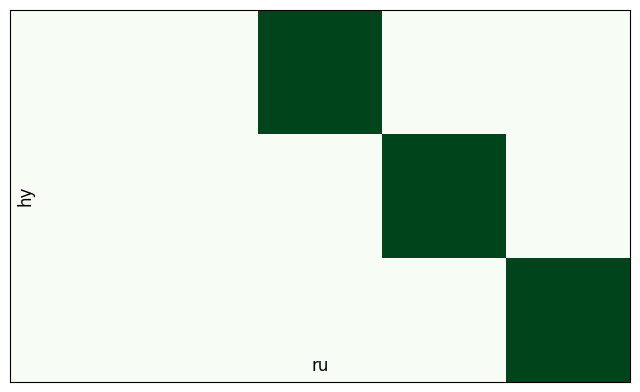

conflicts to solve: 0
total conflicts: 0
conflicts to solve: 0
total conflicts: 0


0it [00:00, ?it/s]


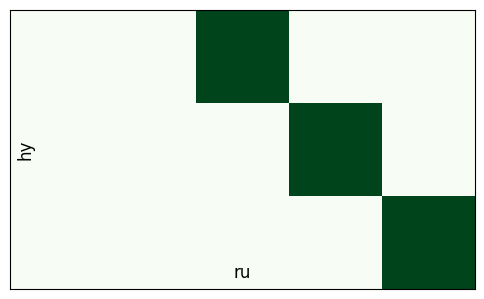

Конфликты разрешены
2 done
--------------------------------------------------
12:42:52
000000004
Загружен оригинальный текст из 000000004_am.txt
Загружен текст перевода из 000000004_ru.txt
❌ НЕПАРАЛЛЕЛЬНЫЕ ТЕКСТЫ 000000004! chrF = 0.61957496158942
3 done
--------------------------------------------------
12:42:55
000000005
Загружен оригинальный текст из 000000005_am.txt
Загружен текст перевода из 000000005_ru.txt
❌ НЕПАРАЛЛЕЛЬНЫЕ ТЕКСТЫ 000000005! chrF = 0.6693323059099346
4 done
--------------------------------------------------


In [ ]:
#@title Запускаем обработку текстов

#@markdown - `INPUT_DIR` -- папка, где лежат пары файлов. Оставляем пустым, если файлы не лежат в какой-либо папке
#@markdown - `OUTPUT_DIR` -- папка, в которую нужно положить выровненные тексты
#@markdown - `LANG_FROM` -- язык оригинала
#@markdown - `LANG_TO` -- язык перевода
#@markdown - `CHECK_CHRF_FLAG` -- нужно ли проверять на параллельность? Включаем только для коротких текстов типа новостных статей

from types import NoneType
import os
import re

INPUT_DIR = '' # @param {"type":"string"}
OUTPUT_DIR = 'result' # @param {"type":"string"}
if not os.path.exists(OUTPUT_DIR):
  os.mkdir(OUTPUT_DIR)

done = os.listdir(OUTPUT_DIR)
done = list(map(lambda f: f.replace('.xlsx', ''), done))

fnames = list(filter(
    lambda f: f.endswith('.txt') and re.sub('(_am|_ru)','', f).replace('.txt', '') not in done+exceptions,
    os.listdir(INPUT_DIR if INPUT_DIR else None)
))
if exceptions_file in fnames:
  fnames.remove(exceptions_file)
fnames = set(map(lambda f: re.sub('(_am|_ru)', '', f).replace('.txt', ''), fnames))

# язык оригинала
LANG_FROM = "hy" # @param ["hy","ru"]
# язык перевода
LANG_TO = "ru" # @param ["hy","ru"]

CHECK_CHRF_FLAG = True # @param {"type":"boolean"}

cntr = 1

for project_name in sorted(fnames):

  if cntr % 500 == 0:
    backup(dir=OUTPUT_DIR, exceptions_file=exceptions_file,
           ts=datetime.datetime.now().strftime('%Y%m%d_%H%M%S'), if_download=False)

  print(datetime.datetime.now().strftime('%H:%M:%S'))
  print(project_name)

  cur_timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
  db_path = f"{cur_timestamp}.db"

  # название файла на русском (до .txt)
  ru_input = f"{project_name}_ru"
  # название файла на армянском (до .txt)
  am_input = f"{project_name}_am"
  # print(ru_input, am_input)

  ru_input = ru_input+'.txt'
  am_input = am_input+'.txt'

  # print(ru_input, am_input)

  try:
    pair2Align(
        path_from=os.path.join(INPUT_DIR, am_input) if LANG_FROM == "hy" \
                  else os.path.join(INPUT_DIR, ru_input),
        path_to=os.path.join(INPUT_DIR, am_input) if LANG_TO == "hy" \
                  else os.path.join(INPUT_DIR, ru_input),
        project_name=project_name,
        output_dir=OUTPUT_DIR,
        lang_from=LANG_FROM,
        lang_to=LANG_TO,
        model_name=model_name,
        check_chrf=CHECK_CHRF_FLAG
    )
  except TypeError:
    # ошибка выбрасывается, когда файл состоит из одной строки текста
    simple_align(
        path_from=os.path.join(INPUT_DIR, am_input) if LANG_FROM == "hy" \
                  else os.path.join(INPUT_DIR, ru_input),
        path_to=os.path.join(INPUT_DIR, am_input) if LANG_TO == "hy" \
                  else os.path.join(INPUT_DIR, ru_input),
        project_name=project_name,
        output_dir=OUTPUT_DIR,
    )

  cntr += 1

  print(cntr, 'done')
  print('-'*50)

backup(dir=OUTPUT_DIR, exceptions_file=exceptions_file,
       ts=datetime.datetime.now().strftime('%Y%m%d_%H%M%S'), if_download=True)


In [ ]:
print('Исключений:', len(exceptions))
# print(*sorted(exceptions), sep='\n')

Исключений: 3


In [ ]:
# удаляем все

# !rm *.db *.txt *.zip
# !rm -r result

rm: cannot remove '*.db': No such file or directory
